# **Putative disease gene identification and drug repurposing for  *NON-SMALL CELL LUNGS CARCINOMA (NSCLC)***

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import itertools
import math
import random as rd
import json
import statistics
import tqdm
import matplotlib.pyplot as plt
from statistics import mean, stdev

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. **PPI and GDA data gathering & interactome reconstruction**

### *1.1.* *Download and filter PPI from BioGRID*

In [3]:
ppi = pd.read_csv("/content/drive/MyDrive/BI&NM/BIOGRID-ORGANISM-Homo_sapiens-4.4.228.tab3.txt", delimiter = "\t")
ppi.head()

<ipython-input-3-500650770e02>:1: DtypeWarning: Columns (1,2,18) have mixed types. Specify dtype option on import or set low_memory=False.
  ppi = pd.read_csv("/content/drive/MyDrive/BI&NM/BIOGRID-ORGANISM-Homo_sapiens-4.4.228.tab3.txt", delimiter = "\t")


#BioGRID Interaction ID Entrez Gene Interactor A Entrez Gene Interactor B  \
0                      103                     6416                     2318   
1                      117                    84665                       88   
2                      183                       90                     2339   
3                      278                     2624                     5371   
4                      418                     6118                     6774   

   BioGRID ID Interactor A  BioGRID ID Interactor B  \
0                   112315                   108607   
1                   124185                   106603   
2                   106605                   108625   
3                   108894                   111384   
4                   112038                   112651   

  Systematic Name Interactor A Systematic Name Interactor B  \
0                            -                            -   
1                            -                            -   
2                            -                            -   
3                            -                            -   
4                  RP4-547C9.3                            -   

  Official Symbol Interactor A Official Symbol Interactor B  \
0                       MAP2K4                         FLNC   
1                         MYPN                        ACTN2   
2                        ACVR1                         FNTA   
3                        GATA2                          PML   
4                         RPA2                        STAT3   

                               Synonyms Interactor A  ...  \
0  JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...  ...   
1                             CMD1DD|CMH22|MYOP|RCM4  ...   
2            ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI  ...   
3                           DCML|IMD21|MONOMAC|NFE1B  ...   
4                      REPA2|RP-A p32|RP-A p34|RPA32  ...   

  TREMBL Accessions Interactor B  \
0                         Q59H94   
1                  Q59FD9|F6THM6   
2                              -   
3                              -   
4                              -   

                      REFSEQ Accessions Interactor B Ontology Term IDs  \
0                             NP_001120959|NP_001449                 -   
1                NP_001094|NP_001265272|NP_001265273                 -   
2                                          NP_002018                 -   
3  NP_150250|NP_150253|NP_150252|NP_150247|NP_150...                 -   
4  NP_644805|NP_003141|NP_001356447|NP_001356443|...                 -   

  Ontology Term Names Ontology Term Categories  Ontology Term Qualifier IDs  \
0                   -                        -                            -   
1                   -                        -                            -   
2                   -                        -                            -   
3                   -                        -                            -   
4                   -                        -                            -   

   Ontology Term Qualifier Names Ontology Term Types  \
0                              -                   -   
1                              -                   -   
2                              -                   -   
3                              -                   -   
4                              -                   -   

  Organism Name Interactor A Organism Name Interactor B  
0               Homo sapiens               Homo sapiens  
1               Homo sapiens               Homo sapiens  
2               Homo sapiens               Homo sapiens  
3               Homo sapiens               Homo sapiens  
4               Homo sapiens               Homo sapiens  

[5 rows x 37 columns]

In [4]:
# define a function to filter the table
def filter(data):

  # keep only human interactions
  interactions = data[(ppi["Organism ID Interactor A"] == 9606) & (data["Organism ID Interactor B"] == 9606)]
  # keep only physical interactions
  phy = interactions[(interactions["Experimental System Type"] == "physical")]

  # remove self-loops (we used BioGRID ID as unique identificator)
  self_cond = phy[(phy["Official Symbol Interactor A"] != phy["Official Symbol Interactor B"])]

  # remove redundancies
  result = self_cond[~self_cond[["Official Symbol Interactor A", "Official Symbol Interactor B"]].duplicated()]
  return result


fppi = filter(ppi)

# in order to make the code more efficient, some columns can be removed
fppi.drop(columns = ['Organism Name Interactor A', 'Organism Name Interactor B'])

# final data looks like:
fppi.head(10)

#BioGRID Interaction ID Entrez Gene Interactor A Entrez Gene Interactor B  \
0                      103                     6416                     2318   
1                      117                    84665                       88   
2                      183                       90                     2339   
3                      278                     2624                     5371   
4                      418                     6118                     6774   
5                      586                      375                    23163   
6                      612                      377                    23647   
7                      617                      377                    27236   
8                      663                    54464                      226   
9                      866                      351                    10513   

   BioGRID ID Interactor A  BioGRID ID Interactor B  \
0                   112315                   108607   
1                   124185                   106603   
2                   106605                   108625   
3                   108894                   111384   
4                   112038                   112651   
5                   106870                   116775   
6                   106872                   117174   
7                   106872                   118084   
8                   119970                   106728   
9                   106848                   115769   

  Systematic Name Interactor A Systematic Name Interactor B  \
0                            -                            -   
1                            -                            -   
2                            -                            -   
3                            -                            -   
4                  RP4-547C9.3                            -   
5                            -                            -   
6                            -                            -   
7                            -                            -   
8                            -                            -   
9                            -                            -   

  Official Symbol Interactor A Official Symbol Interactor B  \
0                       MAP2K4                         FLNC   
1                         MYPN                        ACTN2   
2                        ACVR1                         FNTA   
3                        GATA2                          PML   
4                         RPA2                        STAT3   
5                         ARF1                         GGA3   
6                         ARF3                       ARFIP2   
7                         ARF3                       ARFIP1   
8                         XRN1                        ALDOA   
9                          APP                       APPBP2   

                               Synonyms Interactor A  ...  \
0  JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...  ...   
1                             CMD1DD|CMH22|MYOP|RCM4  ...   
2            ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI  ...   
3                           DCML|IMD21|MONOMAC|NFE1B  ...   
4                      REPA2|RP-A p32|RP-A p34|RPA32  ...   
5                                                  -  ...   
6                                                  -  ...   
7                                                  -  ...   
8                                               SEP1  ...   
9    AAA|ABETA|ABPP|AD1|APPI|CTFgamma|CVAP|PN-II|PN2  ...   

  TREMBL Accessions Interactor B  \
0                         Q59H94   
1                  Q59FD9|F6THM6   
2                              -   
3                              -   
4                              -   
5                  B7Z456|A8K6M0   
6       B4DUZ3|B4DXH2|A0A087X1E4   
7           B4E273|B4DS69|Q8N8M9   
8                         V9HWN7   
9                     A0A024QZ47   

                      REFSEQ Accessions Interactor B Ontolo

In [5]:
# create the table for Cytoscape

cyto_net = fppi[["Official Symbol Interactor A", "Official Symbol Interactor B"]]

cyto_net["directed"] = np.repeat("false", len(cyto_net))
cyto_net.to_csv("Custom_ppi.csv")

<ipython-input-5-12cdfa118060>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cyto_net["directed"] = np.repeat("false", len(cyto_net))


In [5]:
# get the graph to keep only the largest connected component

# build the graph from DataFrame
bio = nx.from_pandas_edgelist(fppi,
                              source = "Official Symbol Interactor A",
                              target = "Official Symbol Interactor B",
                              create_using=nx.Graph())      # nx.Graph() doesn't allow duplicated edges


print(bio)

# check how many connected components the graph has and keep only the largest
print([len(c) for c in sorted(nx.connected_components(bio), key=len, reverse=True)])

Graph with 19816 nodes and 809943 edges
[19816]


The graph already has only one LCC. No further manipulation is necessary.


**NOTE- Visualization** : In order to visualize the network , since the whole graph is too big, it seems appropriate to choose a gene and visualize its *ego network*. A [seed gene](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7507563/) (MET) of NSCLC has been selected.

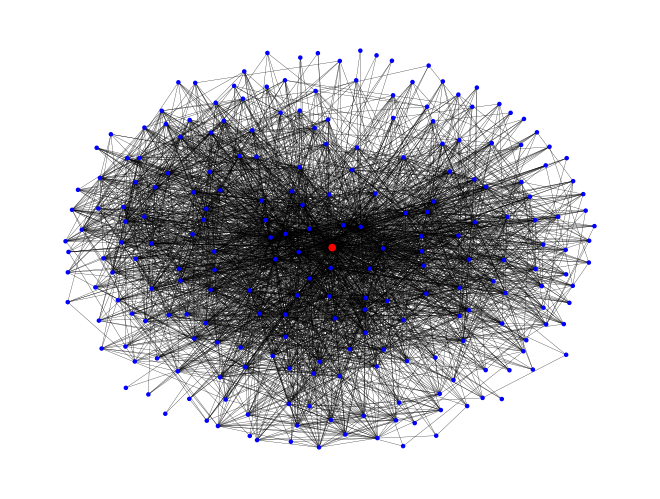

In [7]:
# visualize the ego network of a particular gene

sub = nx.ego_graph(bio, "MET")

color_map = ['red' if node == "MET" else 'blue' for node in sub]
nodew = [20 if node == "MET" else 5 for node in sub]
nx.draw_kamada_kawai(sub, node_color = color_map, node_size =nodew, width = 0.2)

### *1.2.* *Gather gene-disease associations (GDAs) from DisGeNET*

In [6]:
# get the table
disease = pd.read_csv("/content/drive/MyDrive/BI&NM/C0007131_disease_gda_summary_CURATED.tsv", delimiter = "\t")
disease.head()

Disease Disease_id    Gene  Gene_id        UniProt  \
0  Non-Small Cell Lung Carcinoma   C0007131    EGFR     1956         P00533   
1  Non-Small Cell Lung Carcinoma   C0007131    KRAS     3845         P01116   
2  Non-Small Cell Lung Carcinoma   C0007131     MET     4233         P08581   
3  Non-Small Cell Lung Carcinoma   C0007131  CDKN2A     1029  P42771;Q8N726   
4  Non-Small Cell Lung Carcinoma   C0007131  NFE2L2     4780         Q16236   

                                 Gene_Full_Name     Protein_Class  \
0              epidermal growth factor receptor            Kinase   
1                   KRAS proto-oncogene, GTPase  Enzyme modulator   
2  MET proto-oncogene, receptor tyrosine kinase            Kinase   
3          cyclin dependent kinase inhibitor 2A               NaN   
4            nuclear factor, erythroid 2 like 2            Enzyme   

   N_diseases_g  DSI_g  DPI_g       pLI  Score_gda  EL_gda  EI_gda  N_PMIDs  \
0           124  0.295  0.885  0.368370        0.7     NaN   0.976       16   
1           164  0.320  0.923  0.000788        0.7     NaN   0.979        7   
2            90  0.380  0.846  0.969980        0.6     NaN   0.986        4   
3           115  0.300  0.885  0.394740        0.6     NaN   0.957        2   
4            89  0.357  0.885  0.003572        0.6     NaN   0.962        2   

   N_SNPs_gda  First_Ref  Last_Ref  
0          29       1989      2020  
1          10       1989      2020  
2           0       2002      2020  
3           3       1994      2020  
4           0       2006      2020

The disease is associated to 156 genes.

### *1.3. Compute and characterize the disease LCC and its basic network measures*

From the GDA a list of **seed genes** can be identified in the interactome in order to find the subnetwork of disease genes.

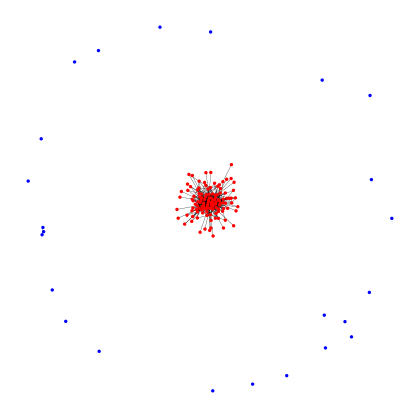

In [8]:
# check for the presence of disease genes in the interactome
inter_nodes = set(list(bio.nodes))
dis_genes = set(disease["Gene"].to_numpy())
seed_genes = list(inter_nodes.intersection(dis_genes))

# not all the elements are in the interactome. In particular, 12 disease genes don't belong to the PPI network.

# define the disease network

sub_seed = bio.subgraph(seed_genes)

# isolate the LCC in the interactome
conn_comp = [c for c in sorted(list(nx.connected_components(sub_seed)), key=len, reverse=True)]
LCC_nodes = conn_comp[0]
color_map = ['red' if node in LCC_nodes else 'blue' for node in list(sub_seed.nodes())]
plt.figure(3,figsize=(4,4))

nx.draw_spring(sub_seed,node_color = color_map,  node_size = 2, width = 0.2 )

In [9]:
# create files with the seed genes to select DGAs
with open("seed_genes.txt", "w") as f:
  for item in seed_genes:
    f.write(item +"\n")
with open("LCC_seed_genes.txt", "w") as f:
  for item in LCC_nodes:
    f.write(item +"\n")

In [10]:
# create Table 1: Summary of GDAs and basic network data
'''
NOTE: for clarifications on the MeSH term, take a look @:
https://www.ncbi.nlm.nih.gov/mesh?Db=mesh&Cmd=DetailsSearch&Term="Carcinoma,+Non-Small-Cell+Lung"%5BMeSH+Terms%5D
C08 : respiratory tract disease
'''

tab1 = pd.DataFrame({'disease name': ['NSCLC'], 'UMLS disease ID': ['C0007131'],
                     'MeSH disease class': ['C08'], 'number of associated genes': len(dis_genes),
                     'number of genes present in the interactome': len(seed_genes),
                     'LCC size of the disease interactome': len(LCC_nodes) })
tab1

disease name UMLS disease ID MeSH disease class  number of associated genes  \
0        NSCLC        C0007131                C08                         156   

   number of genes present in the interactome  \
0                                         144   

   LCC size of the disease interactome  
0                                  120

#### Insight on the LCC of the disease: *Is the disease module also a topological module?*


An interesting phenomenon can be observed: if the neighbors of the seed genes are added in the network, the connected component of the disease network is one.

In [11]:
# define the subnetwork of nodes and  get LCC of the disease

# get the neighbors of the seed genes
all_adj = list(set(itertools.chain(*[list(bio.adj[gene]) for gene in seed_genes])))
nodes_to_vis = seed_genes + all_adj

# get the subgraph
ego_seed = bio.subgraph(nodes_to_vis)

# isolate the LCC in the interactome
conn_comp = [c for c in sorted(list(nx.connected_components(ego_seed)), key=len, reverse=True)]

print("# of connected components:", len(conn_comp))

color_map = ['red' if gene in seed_genes else 'blue' for gene in list(sub_seed.nodes())]

# of connected components: 1


In [ ]:
len(set(all_adj).intersection(seed_genes))

122

In [ ]:
len(ego_seed.nodes())

9854

The fact that the subgraph containing seed genes and their neighbors has only one connected component has to be explored. Is it given by chance, or is it related to the nature of the disease under analysis?
Since this connected component contains 9854 nodes, the visualization of the graph is not effective. Remember the objective is finding the disease module a check on the modularity properties of this network could be useful. For this reason we refer to related literature.

For instance, the modularity properties have been studied by Wang et al. ([Knowledge-Guided “Community Network” Analysis Reveals the Functional Modules and Candidate Targets in Non-Small-Cell Lung Cancer](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7919838/)).  This study is interesting also because the seed genes-based disease network has been constructed according to a weighting system of the more likely disease-associated nodes and edges in the interactome. The results show the presence of 8 communities in the disease network. Two of them, identified as modules, represent, rispectively, the diagnostic module biomarker and the potential drug targets.

##### Let's use **Louvain** algorithm for now.

In [ ]:
Louvain_partitions = nx.community.louvain_communities(bio)
Louvain_partitions

The graph can be partitioned in 9 communities (topological modules) according to Louvain algorithm implemented by `networkx` library. We want to find out if one of them can be overlapped to the disease module.

In [ ]:
L_cl_len = sorted([len(Louvain_partitions[i]) for i in range(len(Louvain_partitions))], reverse = True)
L_cl_len

[4934, 3902, 3425, 3081, 2480, 1286, 662, 39, 7]

In [ ]:
common = pd.DataFrame(columns = ["common nodes", "cluster width"])
common

Empty DataFrame
Columns: [common nodes, cluster width]
Index: []

In [ ]:
# return also the length of the cluster to realize how much the ratio of common node is significative
def find_common_nodes(seed, cluster):
  return len(set(seed).intersection(set(cluster))), len(cluster)

# test it
for i in range(len(Louvain_partitions)):
  print(find_common_nodes(seed_genes, Louvain_partitions[i]))

(0, 7)
(10, 3081)
(7, 2480)
(1, 39)
(5, 1286)
(26, 3425)
(38, 4934)
(54, 3902)
(3, 662)


This clustering algorithm is in contradiction with the previous intuition. Even if the PPI network is incomplete, we can assume that it is not perfectly localized over a topological module of the whole network. Moreover, since we want to consider communities with a number of nodes in the range $[10, 1000]$, the candidate clusters to be considered are those with few known disease genes.

#### *Centrality measures of the disease genes in the disease LCC*

In [12]:
# generate the subgraph LCC
centrality = pd.DataFrame()
LCC = nx.subgraph(sub_seed, LCC_nodes)

# compute average centrality measures of the LCC
centrality['degree'] = [sum(nx.degree_centrality(LCC).values())/len(LCC_nodes)]
centrality['betweenness'] = sum(nx.betweenness_centrality(LCC).values())/len(LCC_nodes)
centrality['eigenvector'] = sum(nx.eigenvector_centrality(LCC).values())/len(LCC_nodes)
centrality['closeness'] = sum(nx.closeness_centrality(LCC).values())/len(LCC_nodes)
centrality['bet_deg'] = centrality['betweenness']/centrality['degree']

In [14]:
display(centrality)

degree  betweenness  eigenvector  closeness   bet_deg
0  0.070028     0.012873     0.066483   0.406903  0.183831

In [13]:
# compute centrality measures of the first 50 disease genes in the disease LCC
degrees = {node: nx.degree(LCC, node) for  node in LCC}
betweenness_centralities = nx.betweenness_centrality(LCC)
eigenvector_centralities = nx.eigenvector_centrality(LCC)
closeness_centralities = nx.closeness_centrality(LCC)

# store centrality measures
rows = []
for node in LCC:
    degree = degrees[node]
    betweenness = betweenness_centralities[node]
    eigenvector = eigenvector_centralities[node]
    closeness = closeness_centralities[node]
    ratio = betweenness / degree

    rows.append([node, degree, betweenness, eigenvector, closeness, ratio])

In [16]:
# create a dataframe of centrality measures
network_summary = pd.DataFrame(rows, columns=["gene", "degree", "betweenness_centrality", "eigenvector_centrality", "closeness_centrality", "betweenness_degree_ratio"])
network_summary.to_csv("network_summary.csv")

# sort it by degree from the highest down
network_summary.sort_values("degree", ascending=False, inplace=True, ignore_index = True)
display(network_summary.head(50))

gene  degree  betweenness_centrality  eigenvector_centrality  \
0       MYC      51                0.187884                0.333005   
1      TP53      38                0.103346                0.271803   
2      EGFR      34                0.128787                0.181036   
3      RAF1      33                0.095293                0.242075   
4      AKT1      29                0.057696                0.235590   
5      BAP1      27                0.048442                0.203356   
6     STAT3      24                0.083169                0.149455   
7      MDM2      22                0.052306                0.168784   
8     ERBB2      20                0.052483                0.148017   
9       RB1      20                0.038938                0.153424   
10    KDM1A      20                0.035551                0.153447   
11     PTEN      19                0.031261                0.154850   
12    HIF1A      19                0.036608                0.155562   
13  SMARCA4      18                0.018154                0.162677   
14     ENO1      18                0.033945                0.142004   
15     SOX2      17                0.033361                0.102640   
16     KRAS      17                0.029091                0.107465   
17    STK11      16                0.006432                0.164125   
18    ITGB1      16                0.030582                0.089893   
19   CDKN2A      15                0.005914                0.160779   
20   MAP2K1      14                0.016123                0.101539   
21    UCHL1      14                0.024877                0.136475   
22     E2F1      14                0.011206                0.119422   
23     CYLD      14                0.018582                0.095390   
24     TERT      14                0.006359                0.130939   
25     NRAS      13                0.012620                0.105388   
26      MET      13                0.007275                0.128354   
27     PPIA      12                0.033092                0.091418   
28   RASSF1      12                0.002313                0.130992   
29  TP53BP1      12                0.012023                0.091853   
30   NFE2L2      12                0.005238                0.111608   
31   CORO1C      11                0.030567                0.087217   
32     MTOR      11                0.022277                0.090739   
33     BRAF      11                0.003114                0.089107   
34      CAT      10                0.021330                0.073439   
35    PRDX1      10                0.003299                0.096926   
36   MAP2K2      10                0.004253                0.072576   
37    SHMT2      10                0.008516                0.082324   
38    CASP8      10                0.017353                0.084558   
39     E2F6      10                0.005950                0.069503   
40   PIK3CA       9                0.022997                0.076999   
41   LGALS1       9                0.006696                0.070607   
42    PHGDH       9                0.006908                0.080790   
43    KEAP1       9                0.019762                0.079134   
44    FGFR1       9                0.016985                0.054837   
45      PXN       9                0.005984                0.061222   
46   LRRC59       8                0.018427                0.070540   
47      ALK       8                0.004924                0.039393   
48    GSTP1       8                0.002677                0.078274   
49    PGAM1       7                0.002409                0.053918   

    closeness_centrality  betweenness_degree_ratio  
0               0.597990                  0.003684  
1               0.550926                  0.002720  
2               0.528889                  0.003788  
3               0.540909                  0.002888  
4               0.533632                  0.001990  
5               0.510730                  0.001794  
6             

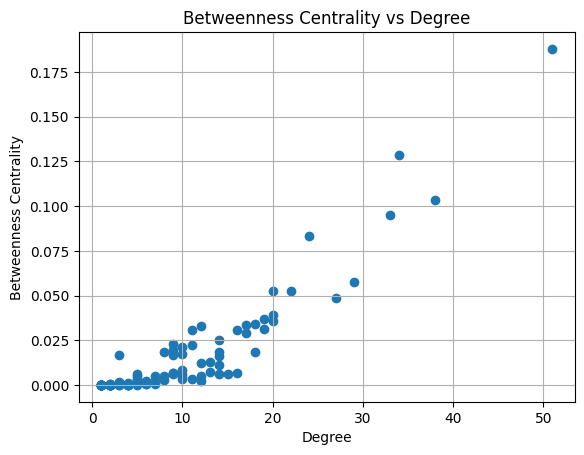

In [17]:
# display the scatterplot of node degree vs node betweenness

plt.scatter(network_summary.degree, network_summary.betweenness_centrality)
plt.xlabel("Degree")
plt.ylabel("Betweenness Centrality")
plt.title("Betweenness Centrality vs Degree")
plt.savefig("betweenness_centrality_vs_degree.eps", format="eps")
plt.grid()

As we can see, lower values of betweenness centrality correspond to lower values of betweenness centrality. The network of the disease, in particular the largest connected component, has probably one *hub* node, the one in the upper-right corner. The other nodes in the network are for the majority weakly connected.

## 2. **Comparative analysis of the disease genes identification algorithms**


### *2.1.* *Candidate seed genes identification*

#### *DIAMOnD algorithm*

In [18]:
# import the DIAMOnD library

import os
import sys
user = "dinaghiassian"
repo = "DIAMOnD"

# remove local directory if it already exists
if os.path.isdir(repo):
    !rm -rf {repo}

# clone the repository where the algorithm can be found
!git clone https://github.com/{user}/{repo}.git

sys.path.insert(0,'/content/DIAMOnD')

import DIAMOnD as D

Cloning into 'DIAMOnD'...
remote: Enumerating objects: 64, done.
remote: Total 64 (delta 0), reused 0 (delta 0), pack-reused 64
Receiving objects: 100% (64/64), 30.11 KiB | 1.08 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [ ]:
print(bio)

Graph with 19816 nodes and 809943 edges


In [19]:
'''
NOTE: set alpha = 2 because the other weights for the node gave too small p-values for the hypergeometric test
'''

# apply the algorithm from the provided library
# save, in a txt file, the first 100 candidates
DIAMOnD_genes = D.DIAMOnD(bio, seed_genes, 100, 2, "DIAMOnD_candidate_genes.txt")

In [20]:
# visualize the list of candidate genes in a dataframe
'''
Each of them is provided with the number of iterations (#rank), the name and
the connectivity p-value
'''
DIAMOnD_genes = pd.read_csv("DIAMOnD_candidate_genes.txt", delimiter ="\t")
DIAMOnD_cand = list(DIAMOnD_genes["DIAMOnD_node"])

# display the first 10 candidates
DIAMOnD_genes.head(10)

#rank DIAMOnD_node       p_hyper
0      1     HSP90AA1  2.192687e-36
1      2       TRIM67  1.351402e-47
2      3        MAPK1  6.341626e-49
3      4     HSP90AB1  1.312494e-46
4      5          SRC  4.378140e-49
5      6       CTNNB1  4.459470e-51
6      7        GSK3B  1.105150e-50
7      8        MAPK3  4.152163e-50
8      9        CDC37  1.098086e-49
9     10         PTK2  5.374271e-51

#### *DiaBLE algorithm*

In [ ]:
# define the function to compute the dynamic universe, at each iteration universe = seed genes + candidate gene-based universe

def smallest_local_expansion(graph, seed):
  # get the neighbors of the seed genes
  all_adj = list(set(itertools.chain(*[list(bio.adj[gene]) for gene in seed])))
  nodes_to_vis = seed + all_adj
  sub = nx.subgraph(graph, nodes_to_vis)
  return sub

#-------------------------------- DiaBLE Function ------------------------------------

DiaBLE_genes = {}
def DiaBLE(graph, seed, n_iter, alpha = 2, output_file_name = "DiaBLE_candidate_genes.txt" ):
  temp_seed = seed.copy()

  for i in range(n_iter):
    # change the universe at each iteration
    sub_universe = smallest_local_expansion(graph, temp_seed)
    DiaBLE_genes[i] = D.DIAMOnD(sub_universe, temp_seed, 1, alpha, "DiaBLE_candidate_gene.txt")
    # update the list of seed genes
    temp_seed.append(DiaBLE_genes[i][0][0])


  # save in a txt file the info about candidates
  with open(output_file_name, "w") as file:
    file.write('\t'.join(['#rank', 'DiaBLE_node', 'p_hyper']) + '\n')
    for key, node_info in zip(range(n_iter), DiaBLE_genes.values()):
      candidate_gene = node_info[0]
      DiaBLE_node = candidate_gene[0]
      p = float(candidate_gene[3])

      file.write('\t'.join(map(str, ([key, DiaBLE_node, p]))) + '\n')
  return DiaBLE_genes

# run the algorithm and store in a txt file thefirst 100 candidates (results are omitted to be displayed better in the following line)
DiaBLE(bio, seed_genes, 100 ,2,  "DiaBLE_candidate_genes.txt")

In [22]:
DiaBLE_cand_df = pd.read_csv("DiaBLE_candidate_genes.txt", delimiter = "\t")

In [23]:
# create the file with the candidate seed genes coming from DiaBLE
DiaBLE_cand = list(DiaBLE_cand_df["DiaBLE_node"])
with open("DiaBLe_100_candidates.txt", "w") as f:
  for item in DiaBLE_cand:
    f.write(item + "\n")

# display the first 10 candidates
DiaBLE_cand_df.head(10)

#rank DiaBLE_node       p_hyper
0      0    HSP90AA1  5.244905e-21
1      1       MAPK8  3.252239e-20
2      2        CD44  1.046242e-19
3      3        CDK6  2.308913e-21
4      4      CDKN2B  6.375723e-21
5      5        CBLC  3.177883e-23
6      6       GLIS2  2.087014e-24
7      7      MAP2K5  4.185075e-23
8      8         NF2  2.746075e-24
9      9       EPHA2  2.737511e-25

In [ ]:
# common candidates between DIAMOnD and DiaBLE
len(set(DiaBLE_cand).intersection(set(DIAMOnD_cand)))

40

DiaBLE and DIAMOnD algorithms predict 40 out of 100 equal nodes.  

#### *Diffusion-based algorithm on Cytoscape*

In [ ]:
# the results from Cytoscape are summarized in the following tables

#------------- t = 0.002 ---------------
cyto002= pd.read_csv("/content/drive/MyDrive/BI&NM/out_002.csv")

#------------- t = 0.005 ---------------
cyto005= pd.read_csv("/content/drive/MyDrive/BI&NM/out_005.csv")

#------------- t = 0.01 ---------------
cyto01= pd.read_csv("/content/drive/MyDrive/BI&NM/out_01.csv")

In [ ]:
cyto_002_df = cyto002.sort_values("diffusion_output_rank", ascending = True, ignore_index = True)

# keep only genes that are not in the seed_genes set
cyto_cg_002 = list(set(cyto_002_df["name"]) - set(seed_genes))[:100]

In [ ]:
# create a file with 100 putative disease genes
with open("CYTO002_100_candidates.txt", "w") as f:
  for item in cyto_cg_002:
    f.write(item + "\n")

In [ ]:
cyto_005_df = cyto005.sort_values("diffusion_output_rank", ascending = True, ignore_index = True)

# keep only genes that are not in the seed_genes set
cyto_cg_005 = list(set(cyto_005_df["name"]) - set(seed_genes))[:100]

In [ ]:
cyto_01_df = cyto01.sort_values("diffusion_output_rank", ascending = True, ignore_index = True)

# keep only genes that are not in the seed_genes set
cyto_cg_01 = list(set(cyto_01_df["name"]) - set(seed_genes))[:100]

In [ ]:
# common candidates between the output using different diffusion times
print("common nodes (t = 0.005, t = 0.01)" ,  len(set(cyto_cg_005).intersection(set(cyto_cg_01))))
print("common nodes (t = 0.005, t = 0.002)" ,  len(set(cyto_cg_005).intersection(set(cyto_cg_002))))
print("common nodes (t = 0.002, t = 0.01)" ,  len(set(cyto_cg_002).intersection(set(cyto_cg_01))))

common nodes (t = 0.005, t = 0.01) 100
common nodes (t = 0.005, t = 0.002) 99
common nodes (t = 0.002, t = 0.01) 99


#### *Comparison visualization*



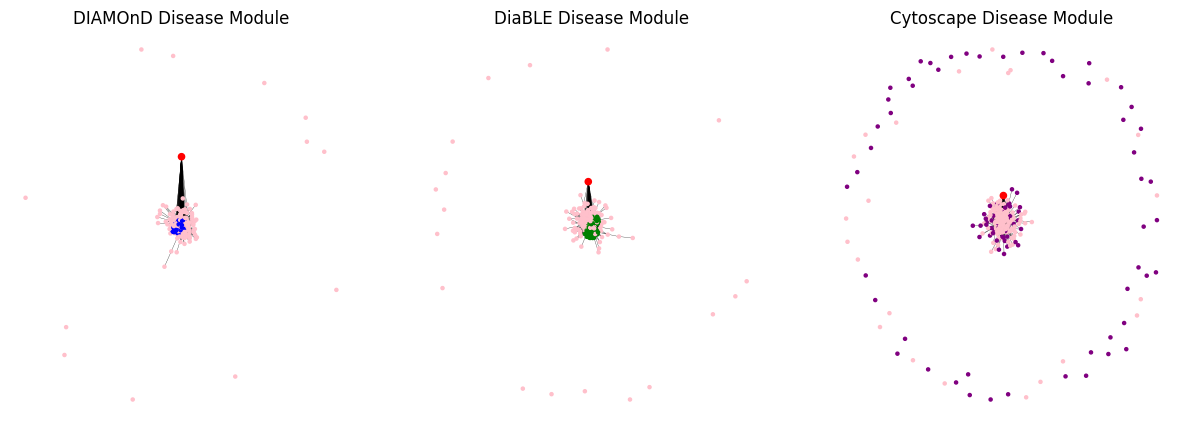

In [ ]:
# visualize the disease module

# select the nodes in the module: seed genes + candidates
DIAMOnD_dm_nodes= list(set(bio.nodes()).intersection(set(DIAMOnD_cand + seed_genes)))
DiaBLE_dm_nodes = list(set(bio.nodes()).intersection(set(DiaBLE_cand + seed_genes)))
Cyto002_dm_nodes = list(set(bio.nodes()).intersection(set(cyto_cg_002 + seed_genes)))

# create the subgraph from the interactome
DIAMOnD_dm = nx.subgraph(bio, DIAMOnD_dm_nodes)
DiaBLE_dm = nx.subgraph(bio, DiaBLE_dm_nodes)
Cyto002_dm = nx.subgraph(bio, Cyto002_dm_nodes)

# discriminate between candidate and known seed genes
color_map_1 = ['pink' if node in seed_genes else 'blue' for node in list(DIAMOnD_dm.nodes())]
color_map_1[list(DIAMOnD_dm.nodes()).index("HSP90AB1")] ="red"

color_map_2= ['pink' if node in seed_genes else 'green' for node in list(DiaBLE_dm.nodes())]
color_map_2[list(DiaBLE_dm.nodes()).index("HSP90AB1")] ="red"

color_map_3= ['pink' if node in seed_genes else 'purple' for node in list(Cyto002_dm.nodes())]
color_map_3[list(Cyto002_dm.nodes()).index("HSP90AB1")] ="red"

# custom the visualization
'''NOTE: in order to better understand the graphs we customize the network layout.
The aim is to highligth the density of connections of the common node in all the candidate disease modules.
The position of the node depends on the degree of the common gene.

'''
center_node = "HSP90AB1"
pos1 = nx.spring_layout(DIAMOnD_dm)
pos1[center_node] = np.array([0, DIAMOnD_dm.degree("HSP90AB1")/244])
pos2 = nx.spring_layout(DiaBLE_dm)
pos2[center_node] = np.array([0, DiaBLE_dm.degree("HSP90AB1")/244])
pos3 = nx.spring_layout(Cyto002_dm)
pos3[center_node] = np.array([0, Cyto002_dm.degree("HSP90AB1")/244])
label = {"HSP90AB1": "COMMON NODE"}

# highlight the first 3 candidate genes for each algorithm
# visualize the differences
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

node_map = [20 if node == "HSP90AB1" else 5 for node in list(DIAMOnD_dm.nodes())]
nx.draw(DIAMOnD_dm, pos = pos1, node_color = color_map_1, node_size = node_map, width = 0.2, ax=axs[0] )
axs[0].set_title("DIAMOnD Disease Module")

node_map = [20 if node == "HSP90AB1" else 5 for node in list(DiaBLE_dm.nodes())]
nx.draw(DiaBLE_dm, pos = pos2, node_color = color_map_2,  node_size = node_map, width = 0.2, ax=axs[1])
axs[1].set_title("DiaBLE Disease Module")

node_map = [20 if node == "HSP90AB1" else 5 for node in list(Cyto002_dm.nodes())]
nx.draw(Cyto002_dm, pos = pos3, node_color = color_map_3,  node_size = node_map, width = 0.2, ax=axs[2] )
axs[2].set_title("Cytoscape Disease Module")

#plt.tight_layout()
plt.axis("off")

plt.show()

We noticed that the three algorithms have only ine gene in common within the candidates. We want to find out if the ranking is high for them. For DIAMOnD it is in the 3rd place, while DiaBLE and Cytoscape diffusion put it at the 51st position.  Notice also that the common gene is in the disease LCC. The degree of *connectedness* of the node within the LCC is highlighted by the height of the common node in the network: the higher the position of the node the more dense the connections (higher degree).

In [ ]:
# ranking position of the common predicted gene of all three algorithms
rank_DIAMOnD = DIAMOnD_cand.index("HSP90AB1")
print(rank_DIAMOnD)
rank_DiaBLE = DiaBLE_cand.index("HSP90AB1")
print(rank_DiaBLE)
rank_Cyto = cyto_cg_01.index("HSP90AB1")
print(rank_Cyto)

3
51
51


In [ ]:
set(DiaBLE_cand).intersection(set(cyto_cg_01))

{'HSP90AB1'}

### *2.2.* *Computational Validation (5-fold cross validation)*

In [24]:
# split the list of known disease genes
n = math.ceil(len(seed_genes)/5)

# shuffle the list to avoid any kind of bias in the splitting
rd.shuffle(seed_genes)
folds = [seed_genes[i*n:i*n+n] for i in range(math.ceil(len(seed_genes)/n))]
len(folds)

5

#### *DIAMOnD Validation (144 candidates)*

In [ ]:
precision = []
recall= []
f1 = []

# k-fold cross-validation
for i in range(5):
  train = folds[:i]+ folds[i+1:]
  train = [x for xs in train for x in xs]
  probe = folds[i]
  # NOTE: we set a number of iterations equal to 144
  # the alpha parameter is set to 2: it gives double importance to known seed genes at each iteration
  candidates = D.DIAMOnD(bio, train, 144, 2, 'val_DIAMOnD'+str(i)+ '.txt')
  candidates_i = [candidates[j][0] for j in range(len(candidates))]
  true_pos = len(set(candidates_i).intersection(set(probe)))
  false_pos = len(candidates_i) - true_pos
  false_neg = len(probe) - true_pos
  precision.append(true_pos/(true_pos+false_pos))
  recall.append(true_pos/(true_pos+false_neg))
  f1.append(2*(precision[i]*recall[i]/(precision[i]+recall[i])))

*Computational results*

In [ ]:
print('Recall:', mean(recall), "±", stdev(recall))
print('Precision:', mean(precision), "±", stdev(precision))
print('F1:', mean(f1), "±", stdev(f1))

Recall: 0.11133004926108374 ± 0.05185299454952027
Precision: 0.022222222222222223 ± 0.010300275676521755
F1: 0.03704799032127975 ± 0.017183914318663243


#### *DiaBLE Validation (144 candidates)*

In [26]:
precision1= []
recall1= []
f11 = []

#k-fold cross validation
for i in range(5):
  train = folds[:i]+ folds[i+1:]
  train = [x for xs in train for x in xs]
  probe = folds[i]
  # NOTE: we set a number of iterations equal to 144
  candidates = DiaBLE(bio, train, 144, 2, "val_DiaBLE" + str(i)+ ".txt")
  candidates_i = [candidates[j][0][0] for j in range(len(candidates))]
  true_pos = len(set(candidates_i).intersection(set(probe)))
  false_pos = len(candidates_i) - true_pos
  false_neg = len(probe) - true_pos
  precision1.append(true_pos/(true_pos+false_pos))
  recall1.append(true_pos/(true_pos+false_neg))
  f11.append(2*(precision1[i]*recall1[i]/(precision1[i]+recall1[i])))

*Computational results*

In [27]:
print('Recall:', mean(recall1), "±", stdev(recall1))
print('Precision:', mean(precision1), "±", stdev(precision1))
print('F1:', mean(f11), "±", stdev(f11))

Recall: 0.12487684729064039 ± 0.05195526591817625
Precision: 0.024999999999999998 ± 0.010531771450071597
F1: 0.041658825110902006 ± 0.017512937173223126


#### *Cytoscape Validation (144 candidates)*

In [ ]:
# create the different file with the 5 folds
for i in range(5):
  train = folds[:i]+ folds[i+1:]
  train = [x for xs in train for x in xs]
  with open("train" + str(i)+ ".txt", "w") as f:
    for item in train:
      f.write(item + "\n")

In [ ]:
precision2 = []
recall2 = []
f12 = []

val_cyto = []

# open files from Cytoscape
for i in range(5):
  val_cyto.append(pd.read_csv("/content/drive/MyDrive/BI&NM/val_cyto/01_val" + str(i) + ".csv"))

  # take only two columns
  val_cyto[i] = val_cyto[i].iloc[:, 2:4]

In [ ]:
precision2 = []
recall2 = []
f12 = []
for i in range(5):
  probe = folds[i]
  # sort by rank of the corresponding fold
  val_cyto_ranked = val_cyto[i].sort_values("diffusion_output_rank", ascending  = True , ignore_index = True)
  # get first 144 genes
  cand_gene_i = list(val_cyto_ranked["name"])[:144]
  true_pos = len(set(cand_gene_i).intersection(set(probe)))
  false_pos = len(cand_gene_i) - true_pos
  false_neg = len(probe) - true_pos
  precision2.append(true_pos/(true_pos+false_pos))
  recall2.append(true_pos/(true_pos+false_neg))
  f12.append(2*(precision2[i]*recall2[i]/(precision2[i]+recall2[i])))

In [ ]:
print('Recall:', mean(recall2), "±", stdev(recall2))
print('Precision:', mean(precision2), "±", stdev(precision2))
print('F1:', mean(f12), "±", stdev(f12))

Recall: 0.7283251231527094 ± 0.1082749768001928
Precision: 0.14583333333333334 ± 0.023032116599690275
F1: 0.2430030918134158 ± 0.037999842328595


#### *Performance measures selecting X positions (DIAMOnD and DiaBLE)*

In [ ]:
def validation(positions, algo):
    # create dictionary to store metric values
    result_dict = {'precision': {'values': [], 'std_dev': []},
                   'recall': {'values': [], 'std_dev': []},
                   'f1': {'values': [], 'std_dev': []}}

    # iterate over the number of positions (number of putative disease genes)
    for positions in positions:
        precision_list = []
        recall_list = []
        f1_list = []

        # 5-folds cross validation
        for i in range(5):
            train = folds[:i] + folds[i+1:]
            train = [x for xs in train for x in xs]
            probe = folds[i]

            # procedure to find candidates for each algorithm
            if algo == 'DIAMOnD':
                candidates = D.DIAMOnD(bio, train, int(positions), 2, f'val_DIAMOnD_{i}_iter_{positions}.txt')
                candidates_i = [candidates[j][0] for j in range(len(candidates))]
            if algo == 'DiaBLE':
                candidates = DiaBLE(bio, train, int(positions), 2, f'val_DiaBLE_{i}_iter_{positions}.txt')
                candidates_i = [candidates[j][0][0] for j in range(len(candidates))]

            # define quantities needed
            true_pos = len(set(candidates_i).intersection(set(probe)))
            false_pos = len(candidates_i) - true_pos
            false_neg = len(probe) - true_pos

            # define the measures
            precision_list.append(true_pos / (true_pos + false_pos))
            recall_list.append(true_pos / (true_pos + false_neg))

            # control for division by zero
            if precision_list[i] + recall_list[i] != 0:
                f1_list.append(2 * (precision_list[i] * recall_list[i] / (precision_list[i] + recall_list[i])))
            else:
                f1_list.append(0)

        # get measures values
        result_dict['recall']['values'].append(mean(recall_list))
        result_dict['precision']['values'].append(mean(precision_list))
        result_dict['f1']['values'].append(mean(f1_list))

        result_dict['recall']['std_dev'].append(stdev(recall_list))
        result_dict['precision']['std_dev'].append(stdev(precision_list))
        result_dict['f1']['std_dev'].append(stdev(f1_list))

    return result_dict

*Store the results of each metric for each value of X with DIAMOnD*

In [ ]:
N = len(seed_genes)
N

144

In [ ]:
X = [0.1*N, 0.25*N, 50, 0.5*N, N]

In [ ]:
results = validation(X, 'DIAMOnD')

# store values and standard deviations
precision_values_DIAMOnD = results['precision']['values']
recall_values_DIAMOnD = results['recall']['values']
f1_values_DIAMOnD = results['f1']['values']

precision_std_devs_DIAMOnD = results['precision']['std_dev']
recall_std_devs_DIAMOnD = results['recall']['std_dev']
f1_std_devs_DIAMOnD = results['f1']['std_dev']

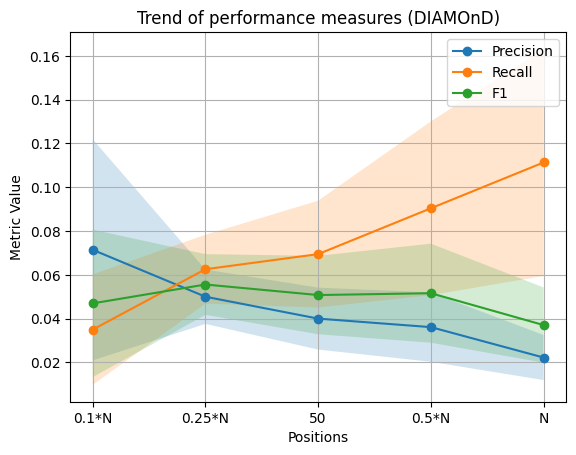

In [ ]:
positions = len(precision_values_DIAMOnD)
# ticks on the x-axis
tks = ['0.1*N', '0.25*N', '50', '0.5*N', 'N']

# plotting measures with standard deviations

plt.plot(tks, precision_values_DIAMOnD, label='Precision', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(precision_values_DIAMOnD, precision_std_devs_DIAMOnD)],
                 [x + s for x, s in zip(precision_values_DIAMOnD, precision_std_devs_DIAMOnD)],
                 alpha=0.2)

plt.plot(tks, recall_values_DIAMOnD, label='Recall', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(recall_values_DIAMOnD, recall_std_devs_DIAMOnD)],
                 [x + s for x, s in zip(recall_values_DIAMOnD, recall_std_devs_DIAMOnD)],
                 alpha=0.2)

plt.plot(tks, f1_values_DIAMOnD, label='F1', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(f1_values_DIAMOnD, f1_std_devs_DIAMOnD)],
                 [x + s for x, s in zip(f1_values_DIAMOnD, f1_std_devs_DIAMOnD)],
                 alpha=0.2)

# labels and title
plt.xlabel('Positions')
plt.ylabel('Metric Value')
plt.xticks(tks)
plt.title('Trend of performance measures (DIAMOnD)')
plt.legend()
plt.grid(True)
plt.show()

*Store the results of each metric for each value of X with DiaBLE*

In [ ]:
results = validation(X, 'DiaBLE')

# store values and standard deviations
precision_values_DiaBLE = results['precision']['values']
recall_values_DiaBLE = results['recall']['values']
f1_values_DiaBLE = results['f1']['values']

precision_std_devs_DiaBLE = results['precision']['std_dev']
recall_std_devs_DiaBLE = results['recall']['std_dev']
f1_std_devs_DiaBLE = results['f1']['std_dev']

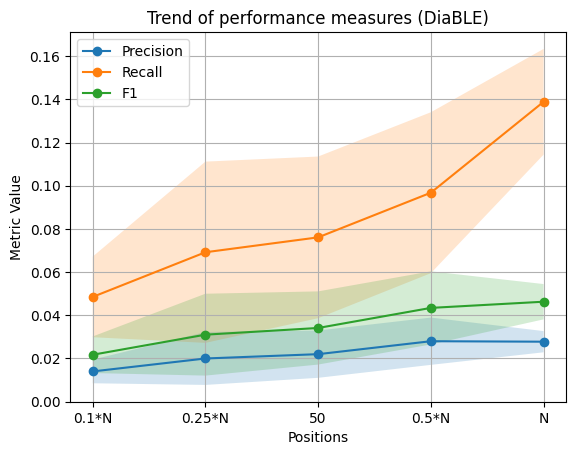

In [ ]:
positions = len(precision_values_DiaBLE)
tks = ['0.1*N', '0.25*N', '50', '0.5*N', 'N']

# plotting measures with standard deviations

plt.plot(tks, precision_values_DiaBLE, label='Precision', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(precision_values_DiaBLE, precision_std_devs_DiaBLE)],
                 [x + s for x, s in zip(precision_values_DiaBLE, precision_std_devs_DiaBLE)],
                 alpha=0.2)

plt.plot(tks, recall_values_DiaBLE, label='Recall', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(recall_values_DiaBLE, recall_std_devs_DiaBLE)],
                 [x + s for x, s in zip(recall_values_DiaBLE, recall_std_devs_DiaBLE)],
                 alpha=0.2)

plt.plot(tks, f1_values_DiaBLE, label='F1', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(f1_values_DiaBLE, f1_std_devs_DiaBLE)],
                 [x + s for x, s in zip(f1_values_DiaBLE, f1_std_devs_DiaBLE)],
                 alpha=0.2)

# labels and title
plt.xlabel('Positions')
plt.ylabel('Metric Value')
plt.xticks(tks)
plt.title('Trend of performance measures (DiaBLE)')
plt.legend()
plt.grid(True)
plt.show()

#### *Performance measures selecting X positions (Diffusion-based algorithm)*

In [ ]:
def validation_cyto(positions):
    result_dict = {'precision': {'values': [], 'std_dev': []},
                   'recall': {'values': [], 'std_dev': []},
                   'f1': {'values': [], 'std_dev': []}}

    for positions in positions:
        precision_list = []
        recall_list = []
        f1_list = []

        for i in range(5):
            probe = folds[i]
            # sort by rank of the corresponding fold
            val_cyto_ranked = val_cyto[i].sort_values("diffusion_output_rank", ascending=True, ignore_index=True)
            # get first 'positions' genes
            cand_gene_i = list(val_cyto_ranked["name"])[:int(positions)]

            true_pos = len(set(cand_gene_i).intersection(set(probe)))
            false_pos = len(cand_gene_i) - true_pos
            false_neg = len(probe) - true_pos

            precision_list.append(true_pos / (true_pos + false_pos))
            recall_list.append(true_pos / (true_pos + false_neg))

            if precision_list[i] + recall_list[i] != 0:
                f1_list.append(2 * (precision_list[i] * recall_list[i] / (precision_list[i] + recall_list[i])))
            else:
                f1_list.append(0)

        result_dict['precision']['values'].append(mean(precision_list))
        result_dict['recall']['values'].append(mean(recall_list))
        result_dict['f1']['values'].append(mean(f1_list))

        result_dict['precision']['std_dev'].append(stdev(precision_list))
        result_dict['recall']['std_dev'].append(stdev(recall_list))
        result_dict['f1']['std_dev'].append(stdev(f1_list))

    return result_dict

*Store the results of each metric for each value of X with Diffusion-based algorithm*

In [ ]:
results = validation_cyto(X)

# store values and standard deviations
precision_values_cyto = results['precision']['values']
recall_values_cyto = results['recall']['values']
f1_values_cyto = results['f1']['values']

precision_std_devs_cyto = results['precision']['std_dev']
recall_std_devs_cyto = results['recall']['std_dev']
f1_std_devs_cyto = results['f1']['std_dev']

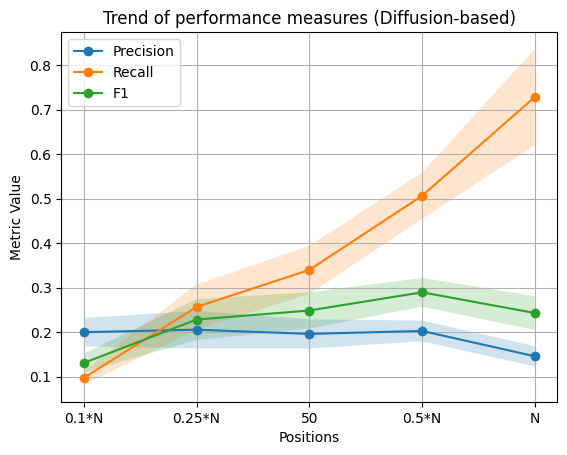

In [ ]:
positions = len(precision_values_cyto)
tks = ['0.1*N', '0.25*N', '50', '0.5*N', 'N']

# plotting measures with standard deviations

plt.plot(tks, precision_values_cyto, label='Precision', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(precision_values_cyto, precision_std_devs_cyto)],
                 [x + s for x, s in zip(precision_values_cyto, precision_std_devs_cyto)],
                 alpha=0.2)

plt.plot(tks, recall_values_cyto, label='Recall', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(recall_values_cyto, recall_std_devs_cyto)],
                 [x + s for x, s in zip(recall_values_cyto, recall_std_devs_cyto)],
                 alpha=0.2)

plt.plot(tks, f1_values_cyto, label='F1', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(f1_values_cyto, f1_std_devs_cyto)],
                 [x + s for x, s in zip(f1_values_cyto, f1_std_devs_cyto)],
                 alpha=0.2)

# labels and title
plt.xlabel('Positions')
plt.ylabel('Metric Value')
plt.xticks(tks)
plt.title('Trend of performance measures (Diffusion-based)')
plt.legend()
plt.grid(True)
plt.show()

*Comparison between the values of the Recall function related to the three algorithms*

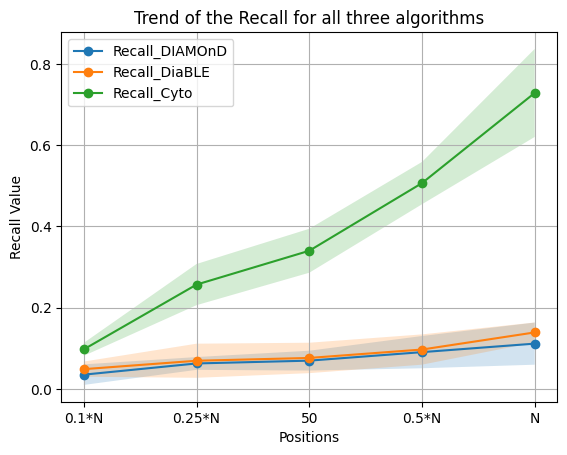

In [ ]:
positions = len(recall_values_cyto)
tks = ['0.1*N', '0.25*N', '50', '0.5*N', 'N']

# plotting measures with standard deviations

plt.plot(tks, recall_values_DIAMOnD, label='Recall_DIAMOnD', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(recall_values_DIAMOnD, recall_std_devs_DIAMOnD)],
                 [x + s for x, s in zip(recall_values_DIAMOnD, recall_std_devs_DIAMOnD)],
                 alpha=0.2)

plt.plot(tks, recall_values_DiaBLE, label='Recall_DiaBLE', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(recall_values_DiaBLE, recall_std_devs_DiaBLE)],
                 [x + s for x, s in zip(recall_values_DiaBLE, recall_std_devs_DiaBLE)],
                 alpha=0.2)

plt.plot(tks, recall_values_cyto, label='Recall_Cyto', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(recall_values_cyto, recall_std_devs_cyto)],
                 [x + s for x, s in zip(recall_values_cyto, recall_std_devs_cyto)],
                 alpha=0.2)

# labels and title
plt.xlabel('Positions')
plt.ylabel('Recall Value')
plt.xticks(tks)
plt.title('Trend of the Recall for all three algorithms')
plt.legend()
plt.grid(True)
plt.show()

*Comparison between the values of the Precision function related to the three algorithms*

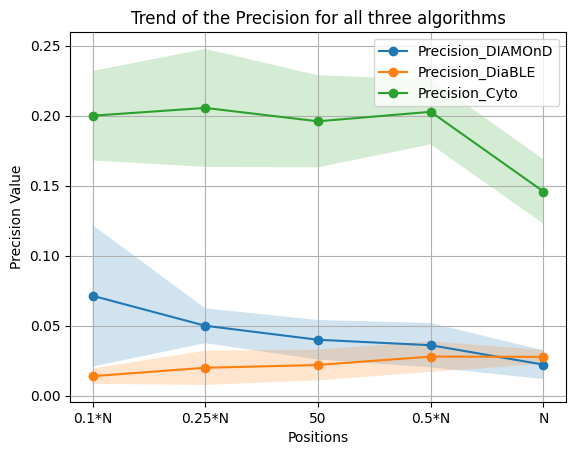

In [ ]:
positions = len(precision_values_cyto)
tks = ['0.1*N', '0.25*N', '50', '0.5*N', 'N']

# plotting measures with standard deviations

plt.plot(tks, precision_values_DIAMOnD, label='Precision_DIAMOnD', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(precision_values_DIAMOnD, precision_std_devs_DIAMOnD)],
                 [x + s for x, s in zip(precision_values_DIAMOnD, precision_std_devs_DIAMOnD)],
                 alpha=0.2)

plt.plot(tks, precision_values_DiaBLE, label='Precision_DiaBLE', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(precision_values_DiaBLE, precision_std_devs_DiaBLE)],
                 [x + s for x, s in zip(precision_values_DiaBLE, precision_std_devs_DiaBLE)],
                 alpha=0.2)

plt.plot(tks, precision_values_cyto, label='Precision_Cyto', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(precision_values_cyto, precision_std_devs_cyto)],
                 [x + s for x, s in zip(precision_values_cyto, precision_std_devs_cyto)],
                 alpha=0.2)

# labels and title
plt.xlabel('Positions')
plt.ylabel('Precision Value')
plt.xticks(tks)
plt.title('Trend of the Precision for all three algorithms')
plt.legend()
plt.grid(True)
plt.show()

*Comparison between the values of the F1 score related to the three algorithms*

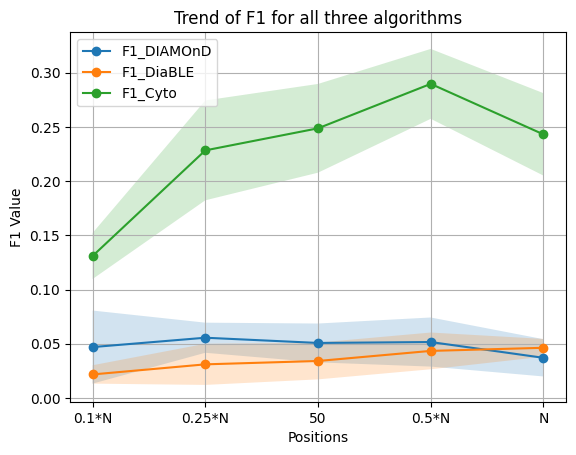

In [ ]:
positions = len(f1_values_cyto)
tks = ['0.1*N', '0.25*N', '50', '0.5*N', 'N']

# plotting measures with standard deviations

plt.plot(tks, f1_values_DIAMOnD, label='F1_DIAMOnD', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(f1_values_DIAMOnD, f1_std_devs_DIAMOnD)],
                 [x + s for x, s in zip(f1_values_DIAMOnD, f1_std_devs_DIAMOnD)],
                 alpha=0.2)

plt.plot(tks, f1_values_DiaBLE, label='F1_DiaBLE', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(f1_values_DiaBLE, f1_std_devs_DiaBLE)],
                 [x + s for x, s in zip(f1_values_DiaBLE, f1_std_devs_DiaBLE)],
                 alpha=0.2)

plt.plot(tks, f1_values_cyto, label='F1_Cyto', marker='o', linestyle='-')
plt.fill_between(tks, [x - s for x, s in zip(f1_values_cyto, f1_std_devs_cyto)],
                 [x + s for x, s in zip(f1_values_cyto, f1_std_devs_cyto)],
                 alpha=0.2)

# labels and title
plt.xlabel('Positions')
plt.ylabel('F1 Value')
plt.xticks(tks)
plt.title('Trend of F1 for all three algorithms')
plt.legend()
plt.grid(True)
plt.show()

## 3. **Putative disease gene identification**

According to the performances of the algorithms evaluated above, we've decided to apply Cytoscape Diffusion-based algorithm with diffusion t = 0.002 to predict new putative disease genes. The result shows the first 100 putative disese genes.

### *3.1.* *Apply the process to predict new putative disease genes using all known GDAs as seed genes*

In [18]:
# load the 100 putative disease genes predicted by the diffusion-based algorithm
Cyto_putative = pd.read_csv("/content/drive/MyDrive/BI&NM/CYTO002_100_candidates.txt", delimiter = "\t", header = None)
Cyto_putative

0
0     ACOT7
1   MACROD2
2    AGAP11
3     MORN2
4      ARTN
..      ...
95   UBE2L3
96    PSMA3
97   FAM63B
98   ERLIN1
99   ZNF408

[100 rows x 1 columns]

## 4. **Drug Repurposing**

### *4.1.* *Drug identification*

*Use the 20 putative disease genes coming from the results of the diffusion-based algorithm*

In [19]:
Cyto_putative_20 = Cyto_putative.head(20)
Cyto_putative_20_list = Cyto_putative_20.iloc[:, 0].tolist()

# display the list of genes
Cyto_putative_20_list

['ACOT7',
 'MACROD2',
 'AGAP11',
 'MORN2',
 'ARTN',
 'WDR45B',
 'MRPL53',
 'ANKRD13A',
 'KLF4',
 'LLGL1',
 'TOE1',
 'NARR',
 'EPHB4',
 'PLAUR',
 'FTSJ2',
 'TBL2',
 'LINC00629',
 'C16orf70',
 'PVR',
 'RPS6KA1']

In [20]:
# load gene-drug interactions dataframe
interactions_df = pd.read_csv("/content/drive/MyDrive/BI&NM/interactions.tsv", delimiter='\t')
# keep only rows where 'approved' column is True
interactions_df = interactions_df[interactions_df['approved'] == True]
interactions_df.head()

gene_claim_name gene_concept_id gene_name interaction_source_db_name  \
0             NRAS       hgnc:7989      NRAS                    JAX-CKB   
7             NRAS       hgnc:7989      NRAS                    JAX-CKB   
15          PIK3CA       hgnc:8975    PIK3CA                    JAX-CKB   
16            PTEN       hgnc:9588      PTEN                    JAX-CKB   
17            PTEN       hgnc:9588      PTEN                    JAX-CKB   

   interaction_source_db_version interaction_type  interaction_score  \
0                       5-Jun-23              NaN           0.065655   
7                       5-Jun-23              NaN           0.107236   
15                      5-Jun-23              NaN           0.013740   
16                      5-Jun-23              NaN           0.048811   
17                      5-Jun-23              NaN           0.190668   

   drug_claim_name drug_concept_id            drug_name approved  \
0      Palbociclib   rxcui:1601374          PALBOCICLIB     True   
7       Lorlatinib   rxcui:2103164           LORLATINIB     True   
15       Docetaxel   rxcui:1299922  DOCETAXEL ANHYDROUS     True   
16       Rucaparib   rxcui:1862579            RUCAPARIB     True   
17       Alpelisib   rxcui:2169285            ALPELISIB     True   

   immunotherapy anti_neoplastic  
0          False            True  
7          False            True  
15         False            True  
16         False            True  
17         False            True

In [21]:
# filter interactions for the first 20 putative disease genes
filtered_interactions = interactions_df[interactions_df['gene_name'].isin(Cyto_putative_20_list)]
filtered_interactions.head()

gene_claim_name gene_concept_id  \
17961                                              KLF4       hgnc:6348   
28638  UROKINASE PLASMINOGEN ACTIVATOR SURFACE RECEPTOR       hgnc:9053   
39254                                             EPHB4       hgnc:3395   
45532                                             PLAUR       hgnc:9053   
79709                                    UNIPROT:Q03405       hgnc:9053   

      gene_name interaction_source_db_name interaction_source_db_version  \
17961      KLF4                   PharmGKB                      5-Jun-23   
28638     PLAUR                        TTD                    2020.06.01   
39254     EPHB4                     ChEMBL                            32   
45532     PLAUR                        NCI                     14-Sep-17   
79709     PLAUR           TdgClinicalTrial                        14-Jan   

      interaction_type  interaction_score drug_claim_name drug_concept_id  \
17961              NaN           3.469415     hydroxyurea      rxcui:5552   
28638              NaN           0.567116     Ruxolitinib   rxcui:1193326   
39254        inhibitor           0.273056      VANDETANIB   rxcui:1098413   
45532              NaN           1.638335           G-CSF     rxcui:70167   
79709              NaN           0.921563       UROKINASE     rxcui:11055   

         drug_name approved immunotherapy anti_neoplastic  
17961  HYDROXYUREA     True         False            True  
28638  RUXOLITINIB     True         False            True  
39254   VANDETANIB     True         False            True  
45532  LENOGRASTIM     True         False           False  
79709    UROKINASE     True         False           False

In [23]:
# compile a ranking of drugs based on the frequency of association
drug = filtered_interactions['drug_name'].value_counts().reset_index()
drug.columns = ['drug_name', 'count']

# sort the drugs based on the count
ranked_drugs = drug.sort_values(by='count', ascending=False)

# print the ranking of identified drugs
print("Ranking of Identified Drugs:")
for rank, (drug, count) in enumerate(ranked_drugs.itertuples(index=False), start=1):
    related_genes = filtered_interactions[filtered_interactions['drug_name'] == drug]['gene_name'].unique()
    gene_list = ', '.join(related_genes)
    print(f"{rank}. {drug}: {count} genes - Genes: {gene_list}")

Ranking of Identified Drugs:
1. HYDROXYUREA: 1 genes - Genes: KLF4
2. RUXOLITINIB: 1 genes - Genes: PLAUR
3. VANDETANIB: 1 genes - Genes: EPHB4
4. LENOGRASTIM: 1 genes - Genes: PLAUR
5. UROKINASE: 1 genes - Genes: PLAUR


### *4.2.* *Clinical Trials validation*

The first three approved drugs related to the *NON-SMALL CELL LUNGS CARCINOMA (NSCLC)* are:
*   HYDROXYUREA: 1 genes
*   RUXOLITINIB: 1 genes
*   VANDETANIB: 1 genes

The number of clinical trials testing the drug for the disease of interest are:
*   HYDROXYUREA: 1 study
*   RUXOLITINIB: 5 studies
*   VANDETANIB: 20 studies

*Comparison of the results considerig DiaBLE putative disease genes*

In [24]:
DiaBLE_putative = pd.read_csv("/content/drive/MyDrive/BI&NM/DiaBLe_100_candidates.txt", delimiter = "\t", header = None)
DiaBLE_putative

0
0   HSP90AA1
1      MAPK8
2       CD44
3       CDK6
4     CDKN2B
..       ...
95    SH2D1A
96     HSH2D
97     GRAP2
98     YWHAZ
99       BLK

[100 rows x 1 columns]

In [25]:
DiaBLE_putative_20 = DiaBLE_putative.head(20)
DiaBLE_putative_20_list = DiaBLE_putative_20.iloc[:, 0].tolist()

# Display the list of genes
DiaBLE_putative_20_list

['HSP90AA1',
 'MAPK8',
 'CD44',
 'CDK6',
 'CDKN2B',
 'CBLC',
 'GLIS2',
 'MAP2K5',
 'NF2',
 'EPHA2',
 'CCND2',
 'HGF',
 'CDK4',
 'ARNT',
 'MAP2K3',
 'BECN1',
 'TEAD2',
 'LATS2',
 'GRM1',
 'CDKN2C']

In [26]:
# Filter interactions for the first 20 putative disease genes
filtered_interactions_DiaBLE = interactions_df[interactions_df['gene_name'].isin(DiaBLE_putative_20_list)]
filtered_interactions_DiaBLE.head()

gene_claim_name gene_concept_id gene_name  \
2543            CDK6       hgnc:1777      CDK6   
2594            CDK6       hgnc:1777      CDK6   
4193            CDK6       hgnc:1777      CDK6   
4422        HSP90AA1       hgnc:5253  HSP90AA1   
4478           EPHA2       hgnc:3386     EPHA2   

           interaction_source_db_name interaction_source_db_version  \
2543                           ChEMBL                            32   
2594                           ChEMBL                            32   
4193  ClearityFoundationClinicalTrial                     15-Jun-13   
4422                              DTC                      5-Jun-23   
4478                              DTC                      5-Jun-23   

     interaction_type  interaction_score     drug_claim_name drug_concept_id  \
2543        inhibitor           0.354022         PALBOCICLIB   rxcui:1601374   
2594        inhibitor           0.867354         ABEMACICLIB   rxcui:1946825   
4193        inhibitor           0.354022         CID 5330286   rxcui:1601374   
4422              NaN           0.029054  MICONAZOLE NITRATE     rxcui:42790   
4478              NaN           0.507653           DASATINIB   rxcui:1546019   

                drug_name approved immunotherapy anti_neoplastic  
2543          PALBOCICLIB     True         False            True  
2594          ABEMACICLIB     True         False            True  
4193          PALBOCICLIB     True         False            True  
4422   MICONAZOLE NITRATE     True         False           False  
4478  DASATINIB ANHYDROUS     True         False            True

In [31]:
# Compile a ranking of drugs based on the frequency of association
drug_DiaBLE = filtered_interactions_DiaBLE['drug_name'].value_counts().reset_index()
drug_DiaBLE.columns = ['drug_name', 'count']
# Sort the drugs based on the count
ranked_drugs_DiaBLE = drug_DiaBLE.sort_values(by='count', ascending=False)
# Print the ranking of identified drugs
print("Ranking of Identified Drugs:")
for rank, (drug, count) in enumerate(ranked_drugs_DiaBLE.itertuples(index=False), start=1):
    related_genes = filtered_interactions_DiaBLE[filtered_interactions_DiaBLE['drug_name'] == drug]['gene_name'].unique()
    gene_list = ', '.join(related_genes)
    print(f"{rank}. {drug}: {count} genes - Genes: {gene_list}")

Ranking of Identified Drugs:
1. PALBOCICLIB: 19 genes - Genes: CDK6, CDK4, CCND2, CDKN2B, MAPK8
2. RIBOCICLIB: 14 genes - Genes: CDK6, CDK4, CCND2
3. ABEMACICLIB: 11 genes - Genes: CDK6, CDK4, CCND2
4. DASATINIB ANHYDROUS: 7 genes - Genes: EPHA2
5. SELUMETINIB: 5 genes - Genes: MAP2K5, MAP2K3, NF2
6. RIBOCICLIB SUCCINATE: 4 genes - Genes: CDK6, CDK4
7. TRILACICLIB: 4 genes - Genes: CDK4, CDK6
8. DEXAMETHASONE: 3 genes - Genes: CDK4, CDK6
9. DABRAFENIB: 2 genes - Genes: MAP2K5, MAP2K3
10. TRILACICLIB DIHYDROCHLORIDE: 2 genes - Genes: CDK6, CDK4
11. REGORAFENIB: 2 genes - Genes: EPHA2
12. CISPLATIN: 2 genes - Genes: CD44, NF2
13. COBIMETINIB: 2 genes - Genes: MAP2K3, MAP2K5
14. MICONAZOLE NITRATE: 2 genes - Genes: HSP90AA1
15. TRAMETINIB DIMETHYL SULFOXIDE: 2 genes - Genes: MAP2K3, MAP2K5
16. APREMILAST: 2 genes - Genes: CDK4, CDK6
17. EVEROLIMUS: 2 genes - Genes: NF2
18. SOMATROPIN (RECOMBINANT DNA ORIGIN): 2 genes - Genes: CDK4, HGF
19. BINIMETINIB: 2 genes - Genes: MAP2K5, MAP2K3
20. 

The first three approved drugs related to the *NON-SMALL CELL LUNGS CARCINOMA (NSCLC)* are:
*   PALBOCICLIB: 5 genes
*   RIBOCICLIB: 3 genes
*   ABEMACICLIB: 3 genes

The number of clinical trials testing the drug for the disease of interest are:
*   PALBOCICLIB: 10 studies
*   RIBOCICLIB: 5 studies
*   ABEMACICLIB: 10 studies



We performed the same procedure taking into account the first 20 putative disease genes coming from the results of DiaBLE algorithm and Diffusion-based algorithm. Findings are interesting: for Cytoscape candidates there are few drugs related to only one gene each of the 20 we have considered but all the studies about the first three drugs ranked are about the disease we are analyzing. For DiaBLE, we have 19 genes related with the first ranked drug, 14 with the second and 11 for the third and the studies on these genes are also all related to our disease of interest.